**Jupyter notebook for test of any type**

In [9]:
import sys
import os
import pandas as pd
from datasets import load_dataset
import os
import numpy as np
import pyspark as ps
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import desc, asc, min, max, to_timestamp, col, count, date_trunc, udf, pandas_udf, PandasUDFType,to_date, date_trunc,length,lower, split, explode, coalesce, concat_ws
import langdetect 
from pyspark.sql.types import StringType, BooleanType
import matplotlib.pyplot as plt
import json
import sparknlp

# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if necessary

# Add the src directory to Python's path
sys.path.append(os.path.join(project_root, "src"))

if project_root not in sys.path:
    sys.path.append(project_root)


In [4]:
from data import s3_utils as s3u
from data import NLP_preprocessing as prep

In [3]:
!wget https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_news/All_external.csv

--2025-03-24 17:31:43--  https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_news/All_external.csv
Resolving huggingface.co (huggingface.co)... 54.192.95.70, 54.192.95.21, 54.192.95.79, ...
Connecting to huggingface.co (huggingface.co)|54.192.95.70|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/a0/19/a01967ba742831f4b6903f146b4f5d9a3d2eeeefa619387e8cc87df2d889332c/5d4c018036bd82ca821da71b7a9c0c7db3289642e0fc6f897ea69f4a0c5135c3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27All_external.csv%3B+filename%3D%22All_external.csv%22%3B&response-content-type=text%2Fcsv&Expires=1742837503&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MjgzNzUwM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2EwLzE5L2EwMTk2N2JhNzQyODMxZjRiNjkwM2YxNDZiNGY1ZDlhM2QyZWVlZWZhNjE5Mzg3ZThjYzg3ZGYyZDg4OTMzMmMvNWQ0YzAxODAzNmJkODJjYTgyMWRhNzFiN2E5YzBjN2RiMzI4OTY0MmUwZ

In [3]:
bucket= "financialdata-sa"
news_external = "RawNews/All_external.csv"

In [ ]:
news1 = s3u.get_csv_as_spark(bucket_name=bucket, s3_key=news_external)

your 131072x1 screen size is bogus. expect trouble
25/03/14 19:16:39 WARN Utils: Your hostname, Andres-F resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/14 19:16:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/14 19:16:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/14 19:16:42 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [ ]:
news1.show(5)

+--------------------+--------------------+------------+--------------------+-----------------+------+-------+-----------+------------+----------------+---------------+
|                Date|       Article_title|Stock_symbol|                 Url|        Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|
+--------------------+--------------------+------------+--------------------+-----------------+------+-------+-----------+------------+----------------+---------------+
|2020-06-05 06:30:...|Stocks That Hit 5...|           A|https://www.benzi...|Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-06-03 06:45:...|Stocks That Hit 5...|           A|https://www.benzi...|Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-05-26 00:30:...|71 Biggest Movers...|           A|https://www.benzi...|       Lisa Levin|  NULL|   NULL|       NULL|        NULL|            NULL|   

In [ ]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Data Exploration") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

In [ ]:
df_csv = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("../data/raw/nasdaq_exteral_data.csv")

In [4]:
df_csv.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Article_title: string (nullable = true)
 |-- Stock_symbol: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Article: string (nullable = true)
 |-- Lsa_summary: string (nullable = true)
 |-- Luhn_summary: string (nullable = true)
 |-- Textrank_summary: string (nullable = true)
 |-- Lexrank_summary: string (nullable = true)



In [9]:
df_csv.show(50)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|          Unnamed: 0|                Date|       Article_title|        Stock_symbol|                 Url|           Publisher|              Author|             Article|         Lsa_summary|        Luhn_summary|    Textrank_summary|Lexrank_summary|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|                 0.0|2023-12-16 23:00:...|Interesting A Put...|                   A|https://www.nasda...|                NULL|                NULL|Investors in Agil...|                NULL|                NULL|                NULL|           NULL|
|The

In [3]:

df_csv_5gb = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .option("quote", "\"") \
    .option("delimiter", ",") \
    .option("mode", "PERMISSIVE") \
    .load("../data/raw/All_external.csv")

In [29]:
df_csv_5gb.describe()

DataFrame[summary: string, Article_title: string, Stock_symbol: string, Url: string, Publisher: string, Author: string, Article: string, Lsa_summary: string, Luhn_summary: string, Textrank_summary: string, Lexrank_summary: string]

In [13]:
df_csv_5gb.show(200)

+--------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|                Date|       Article_title|Stock_symbol|                 Url|           Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|
+--------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|2020-06-05 06:30:...|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-06-03 06:45:...|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-05-26 00:30:...|71 Biggest Movers...|           A|https://www.benzi...|          Lisa Levin|  NULL|   NULL|       NULL|        NULL|  

In [27]:
df_csv_5gb.sort(asc("Date")).show(60)

+-------------------+--------------------+------------+--------------------+--------------+----------+--------------------+-----------+------------+----------------+---------------+
|               Date|       Article_title|Stock_symbol|                 Url|     Publisher|    Author|             Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|
+-------------------+--------------------+------------+--------------------+--------------+----------+--------------------+-----------+------------+----------------+---------------+
|1914-09-16 00:00:00|1914. Русские вой...|        NULL|https://lenta.ru/...|Первая мировая|Библиотека|Бои у Сопоцкина и...|       NULL|        NULL|            NULL|           NULL|
|1914-09-16 00:00:00|1914. Праздновани...|        NULL|https://lenta.ru/...|Первая мировая|Библиотека|Министерство наро...|       NULL|        NULL|            NULL|           NULL|
|1914-09-17 00:00:00|1914. Das ist Nes...|        NULL|https://lenta.ru/...|Первая мировая

In [8]:
df_csv_5gb.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Article_title: string (nullable = true)
 |-- Stock_symbol: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Article: string (nullable = true)
 |-- Lsa_summary: string (nullable = true)
 |-- Luhn_summary: string (nullable = true)
 |-- Textrank_summary: string (nullable = true)
 |-- Lexrank_summary: string (nullable = true)



In [ ]:
df_csv_5gb.select(min("Date").alias("min_date"), max("Date").alias("max_date")).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|1914-09-16 00:00:00|2020-06-11 15:12:35|
+-------------------+-------------------+



In [ ]:
df_csv_5gb.groupBy("Stock_symbol").agg(count("*").alias("ticker_count")) \
       .orderBy("Stock_symbol", ascending=True) \
       .show(50)  # Show top 50 tickers

+------------+------------+
|Stock_symbol|ticker_count|
+------------+------------+
|        NULL|     9804627|
|           A|        2369|
|          AA|        2953|
|         AAC|         379|
|        AADR|          32|
|         AAL|         494|
|        AAMC|         132|
|        AAME|          87|
|         AAN|        1309|
|        AAOI|         452|
|        AAON|         326|
|         AAP|        2214|
|        AAPL|         473|
|         AAU|          85|
|         AAV|         127|
|        AAVL|         191|
|        AAWW|         322|
|        AAXJ|          76|
|          AB|        1065|
|        ABAC|          72|
|        ABAX|         100|
|         ABB|        1433|
|        ABBV|         753|
|         ABC|         722|
|        ABCB|          20|
|        ABCD|         130|
|        ABCO|         408|
|        ABCW|          37|
|        ABDC|         116|
|        ABEV|         309|
|         ABG|         323|
|        ABGB|         204|
|        ABIO|      

In [4]:
df_csv_5gb.groupby(date_trunc("month", "date").alias("month")) \
       .count() \
       .orderBy("month") \
       .show()

NameError: name 'df_csv_5gb' is not defined

In [ ]:
df_csv_5gb.show(10)

+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+-------------------+
|               Date|       Article_title|Stock_symbol|                 Url|           Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|        Date_parsed|
+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+-------------------+
|2020-06-05 08:30:54|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|2020-06-05 08:30:54|
|2020-06-03 08:45:20|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|2020-06-03 08:45:20|
|2020-05-26 02:30:07|71 Biggest Movers...|   

cheaper heuristic to validate the language of the news 

In [5]:
import string

def is_likely_english(text, threshold=0.75):
    if text is None:
        # Here we "pass" the row through
        return True
    if not text:
        return False
    # Keep only letters for ratio calc, or all chars.
    total_chars = len(text)
    if total_chars == 0:
        return False
    
    # Count how many are "basic ASCII" or in the [A-Za-z] range
    ascii_letters = sum(ch in string.printable for ch in text)
    
    ratio = ascii_letters / total_chars
    return ratio >= threshold

In [13]:
is_english_udf = udf(lambda text: is_likely_english(text, 0.9), BooleanType())

df_filtered = (
  df_csv_5gb
    .withColumn("likely_en_title", is_english_udf(col("Article_title")))
    .withColumn("likely_en_article", is_english_udf(col("Article")))
    # Keep the row if either condition is True
    .filter("likely_en_title = true AND likely_en_article = true")
)

In [14]:
df_filtered.write.mode("overwrite").parquet("../data/raw/english_only.parquet")

In [6]:
df_english_only = spark.read.parquet("../data/raw/english_only.parquet")

In [16]:
df_english_only.sort(asc("Date")).show(60)

+-------------------+--------------------+------------+--------------------+---------+--------------------+--------------------+-----------+------------+----------------+---------------+---------------+-----------------+
|               Date|       Article_title|Stock_symbol|                 Url|Publisher|              Author|             Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|likely_en_title|likely_en_article|
+-------------------+--------------------+------------+--------------------+---------+--------------------+--------------------+-----------+------------+----------------+---------------+---------------+-----------------+
|1969-12-31 01:00:00|Montpelier Re Hol...|         MRH|http://www.zacks....|    Zacks|                NULL|                NULL|       NULL|        NULL|            NULL|           NULL|           true|             true|
|2006-10-20 02:00:00|Inco's Net Soars ...|        NULL|http://www.bloomb...|     NULL|         Dale Crofts|Inco Ltd.

In [17]:
df_english_only.select(min("Date").alias("min_date"), max("Date").alias("max_date")).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|1969-12-31 01:00:00|2020-06-11 15:12:35|
+-------------------+-------------------+



In [7]:
df_final = df_english_only.drop("Date_parsed").drop("likely_en_title").drop("likely_en_article")

In [19]:
df_final.show(10)

+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|               Date|       Article_title|Stock_symbol|                 Url|           Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|
+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|2020-06-05 08:30:54|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-06-03 08:45:20|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-05-26 02:30:07|71 Biggest Movers...|           A|https://www.benzi...|          Lisa Levin|  NULL|   NULL|       NULL|        NULL|        

In [6]:
df_final.groupBy("Stock_symbol").agg(count("*").alias("ticker_count")) \
       .orderBy("Stock_symbol", ascending=True) \
       .show(50)  # Show top 50 tickers

+------------+------------+
|Stock_symbol|ticker_count|
+------------+------------+
|        NULL|     8988077|
|           A|        2369|
|          AA|        2953|
|         AAC|         379|
|        AADR|          32|
|         AAL|         494|
|        AAMC|         132|
|        AAME|          87|
|         AAN|        1309|
|        AAOI|         452|
|        AAON|         326|
|         AAP|        2213|
|        AAPL|         473|
|         AAU|          85|
|         AAV|         127|
|        AAVL|         191|
|        AAWW|         322|
|        AAXJ|          76|
|          AB|        1046|
|        ABAC|          72|
|        ABAX|         100|
|         ABB|        1423|
|        ABBV|         753|
|         ABC|         722|
|        ABCB|          20|
|        ABCD|         130|
|        ABCO|         408|
|        ABCW|          37|
|        ABDC|         116|
|        ABEV|         309|
|         ABG|         323|
|        ABGB|         204|
|        ABIO|      

In [12]:
df_time = df_final.withColumn("date_day", to_date("Date", "yyyy-MM-dd"))


In [ ]:
df_time_count = df_time.groupBy("date_day").agg(count("*").alias("articles_count")) \
                      .orderBy("date_day")

In [36]:
pdf_time = df_time_count.toPandas()

# Distribution of articles over time 

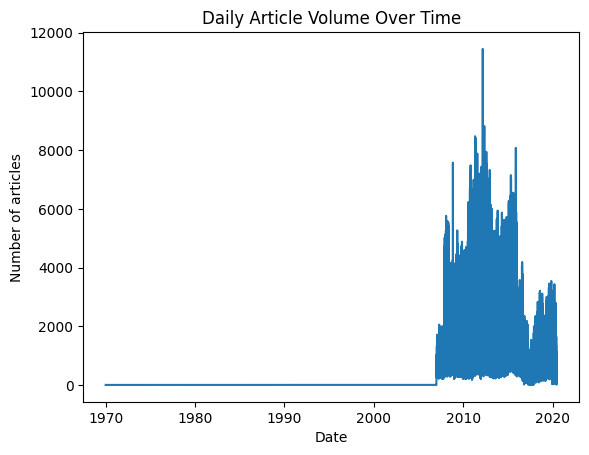

In [39]:
plt.plot(pdf_time["date_day"], pdf_time["articles_count"])
plt.xlabel("Date")
plt.ylabel("Number of articles")
plt.title("Daily Article Volume Over Time")
plt.show()

# Distribution of tickers 

In [44]:
df_ticker_count = df_final.groupBy("Stock_symbol").agg(count("*").alias("ticker_count")) \
                   .orderBy("ticker_count", ascending=False)

In [45]:
df_ticker_count_notnull = df_ticker_count.filter("Stock_symbol IS NOT NULL")

In [50]:
pdf_ticker_notnull = df_ticker_count_notnull.limit(20).toPandas()

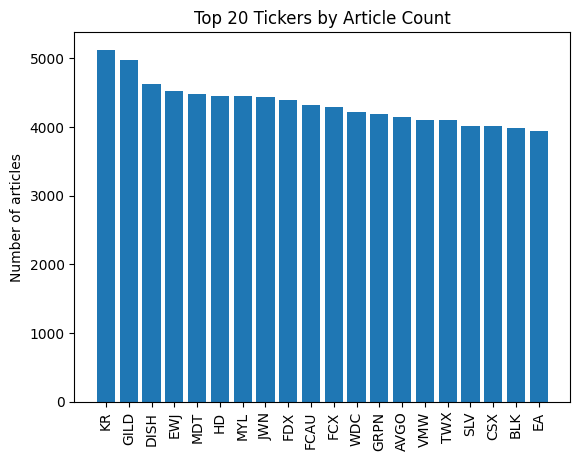

In [51]:
plt.bar(pdf_ticker_notnull["Stock_symbol"], pdf_ticker_notnull["ticker_count"])
plt.xticks(rotation=90)
plt.ylabel("Number of articles")
plt.title("Top 20 Tickers by Article Count")
plt.show()

In [56]:
df_ticker_count_asc = df_final.groupBy("Stock_symbol").agg(count("*").alias("ticker_count")) \
                   .orderBy("ticker_count", ascending=True)

In [57]:
df_ticker_count_notnull_asc = df_ticker_count_asc.filter("Stock_symbol IS NOT NULL")

In [58]:
pdf_ticker_notnull_asc = df_ticker_count_notnull_asc.limit(20).toPandas()

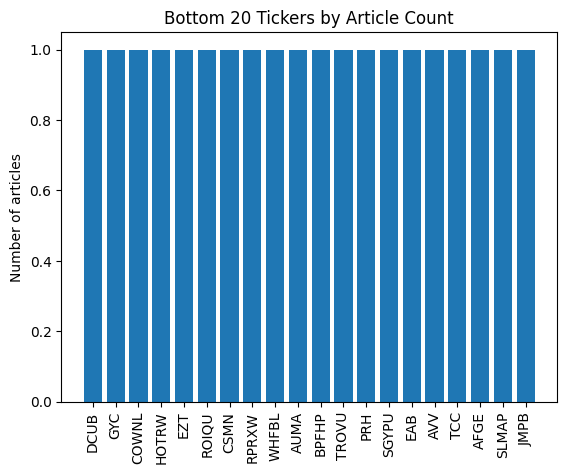

In [59]:
plt.bar(pdf_ticker_notnull_asc["Stock_symbol"], pdf_ticker_notnull_asc["ticker_count"])
plt.xticks(rotation=90)
plt.ylabel("Number of articles")
plt.title("Bottom 20 Tickers by Article Count")
plt.show()

In [61]:
df_len = df_final.withColumn("article_len", length("Article"))
# For a quick stats
df_len.describe(["article_len"]).show()

+-------+------------------+
|summary|       article_len|
+-------+------------------+
|  count|            447307|
|   mean|2784.9296366924727|
| stddev| 2676.569892247614|
|    min|                26|
|    max|             87928|
+-------+------------------+



In [67]:
pdf_len = df_len.select("article_len").sample(fraction=0.1, seed=42).toPandas()  

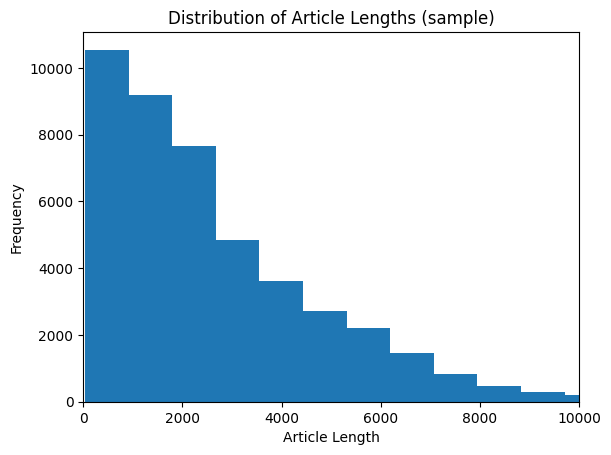

25/03/24 16:48:46 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 14983182 ms exceeds timeout 120000 ms
25/03/24 16:48:47 WARN NettyRpcEnv: Ignored message: true
25/03/24 16:48:47 WARN SparkContext: Killing executors is not supported by current scheduler.
25/03/24 16:48:47 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEn

In [69]:
# sample 10% 
plt.hist(pdf_len["article_len"], bins=100)
plt.xlabel("Article Length")
plt.ylabel("Frequency")
plt.xlim(0, 10000)
plt.title("Distribution of Article Lengths (sample)")
plt.show()

# Quick word frecuency

In [21]:
df_words = df_final.withColumn("title_lower", lower("Article_title")) \
             .withColumn("title_tokens", split("title_lower", "\\s+")) \
             .select(explode("title_tokens").alias("token"))

df_token_count = df_words.groupBy("token").count().orderBy("count", ascending=False)
df_token_count.show(50)

+----------+-------+
|     token|  count|
+----------+-------+
|        to|2844152|
|         -|2052595|
|        of|2007760|
|        in|1814985|
|       and|1608322|
|       for|1555018|
|       the|1452256|
|        on|1309777|
| announces| 648942|
|      with| 634377|
|        at| 631021|
|       new| 615642|
|       net| 570333|
|          | 563248|
|     asset| 548324|
|         a| 528126|
|  value(s)| 492053|
|       reg| 477041|
|        as| 475652|
|    update| 456075|
|   results| 455003|
|    stocks| 387096|
|  earnings| 386659|
|      from| 373110|
|      inc.| 369470|
|         &| 366737|
|    market| 354724|
|      u.s.| 347582|
|      says| 343051|
|   quarter| 341497|
|   reports| 325261|
|        by| 321581|
|    shares| 306234|
|       plc| 296278|
|     group| 294330|
|        up| 290741|
| financial| 266195|
|       etf| 259865|
|  research| 259020|
|        is| 247386|
|    global| 236389|
|     sales| 234781|
|     first| 229997|
|     stock| 226567|
|     after| 

# Date vs Ticker Heatmap

In [ ]:
df_ticker_day = df_time.groupBy("date_day", "Stock_symbol").count()

In [26]:
pdf_ticker_day = df_ticker_day.toPandas()

In [27]:
pivoted = pdf_ticker_day.pivot(index="date_day", columns="Stock_symbol", values="count").fillna(0)

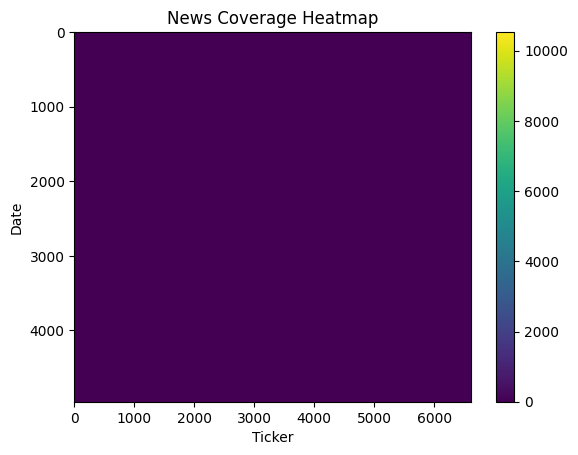

In [28]:
plt.imshow(pivoted.values, aspect='auto')
plt.xlabel("Ticker")
plt.ylabel("Date")
plt.title("News Coverage Heatmap")
plt.colorbar()
plt.show()

top 20 tickers by total coverage

In [ ]:
top_tickers = (
    df_time.groupBy("Stock_symbol")
      .agg(count("*").alias("cnt"))
      .orderBy("cnt", ascending=False)
      .limit(20)
)

In [10]:
top_ticker_list = [row["Stock_symbol"] for row in top_tickers.collect()]

In [11]:
df_sub = df_time.filter(df_time["Stock_symbol"].isin(top_ticker_list))

In [12]:
df_ticker_day_top20 = df_sub.groupBy("date_day", "Stock_symbol").count()

In [13]:
pdf_ticker_day_top = df_ticker_day_top20.toPandas()

In [15]:
pivoted_top = pdf_ticker_day_top.pivot(index="date_day", columns="Stock_symbol", values="count").fillna(0)

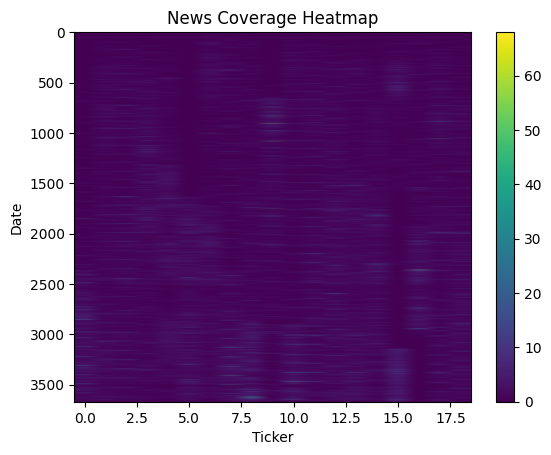

In [16]:
plt.imshow(pivoted_top.values, aspect='auto')
plt.xlabel("Ticker")
plt.ylabel("Date")
plt.title("News Coverage Heatmap")
plt.colorbar()
plt.show()

In [14]:
pivoted_top = pdf_ticker_day_top.pivot(index="date_day", columns="Stock_symbol", values="count").fillna(0)

In [7]:
df_english_only.count()

12239783

In [7]:
df_count = df_time.groupBy("Stock_symbol", "date_day").agg(count("*").alias("news_count"))

In [8]:
df_count = df_count.orderBy(["Stock_symbol", "date_day"])

In [9]:
pdf_count = df_count.toPandas()

In [10]:
pivoted = pdf_count.pivot(index="date_day", columns="Stock_symbol", values="news_count").fillna(0)

In [13]:
# Example: top 10 tickers by total coverage
ticker_agg = df_count.groupBy("Stock_symbol").sum("news_count").orderBy("sum(news_count)", ascending=False)
top_tickers = [row["Stock_symbol"] for row in ticker_agg.limit(10).collect()]

df_top = df_count.filter(df_count["Stock_symbol"].isin(top_tickers))
pdf_top = df_top.toPandas()

In [ ]:
df_top

In [14]:
pivoted_top = pdf_top.pivot(index="date_day", columns="Stock_symbol", values="news_count").fillna(0)

In [ ]:
pivoted_top

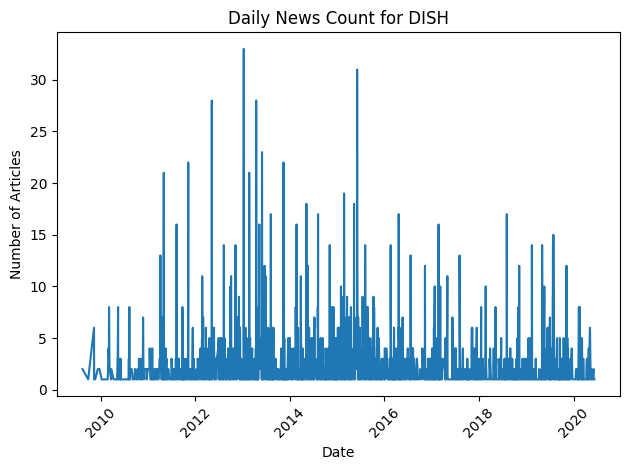

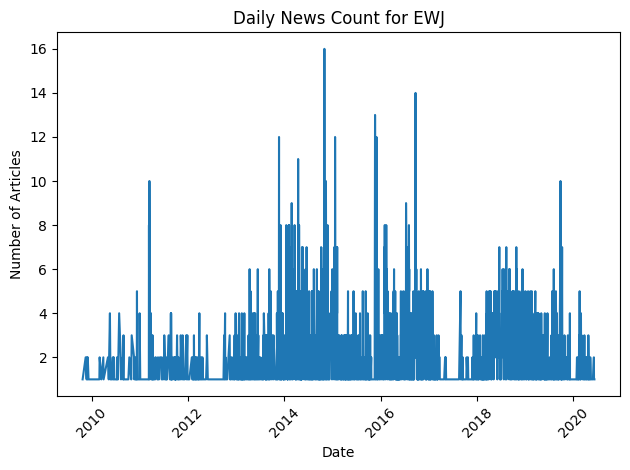

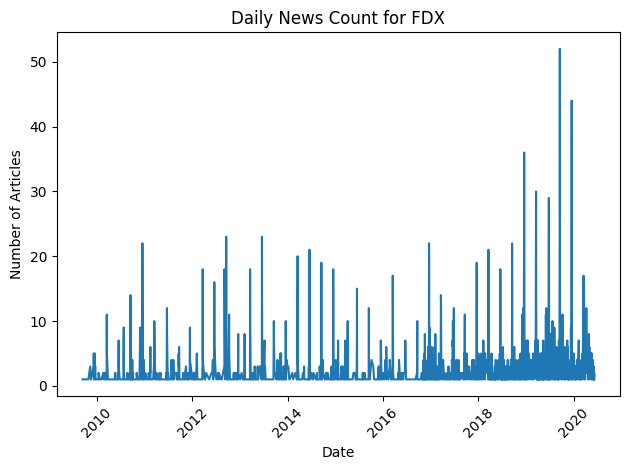

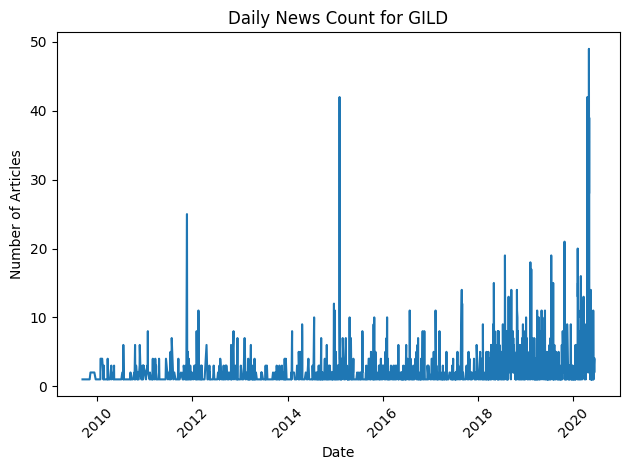

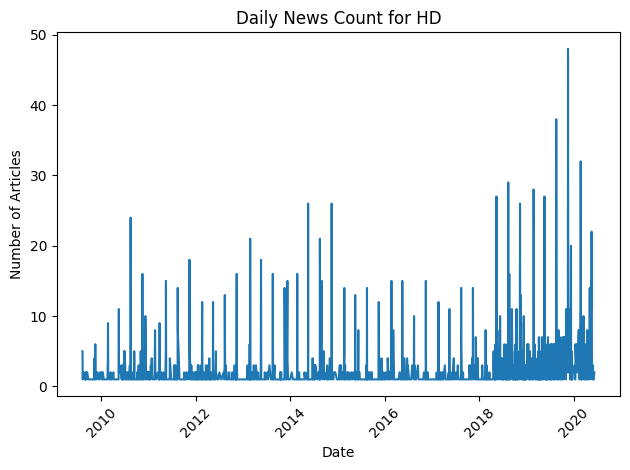

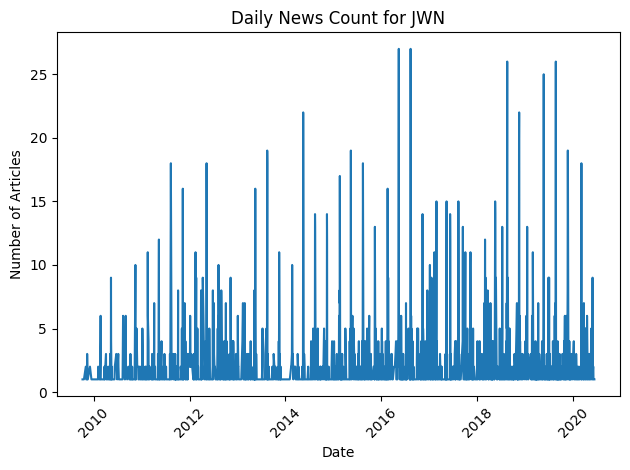

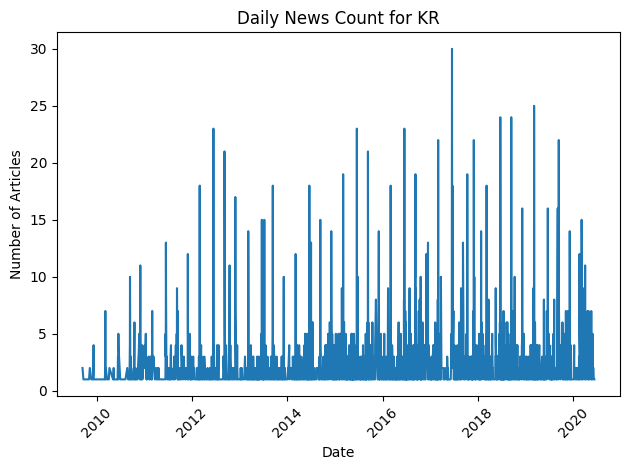

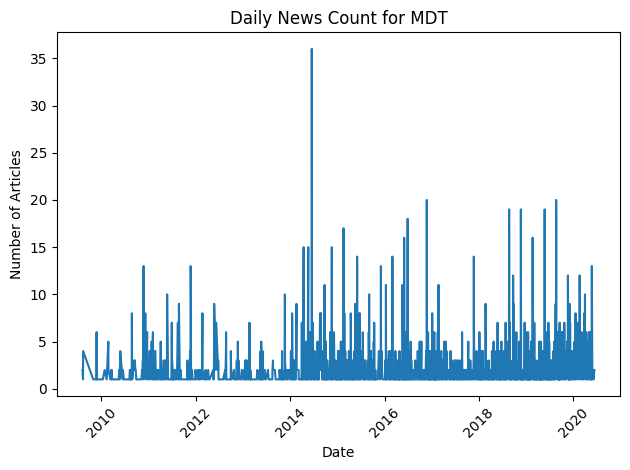

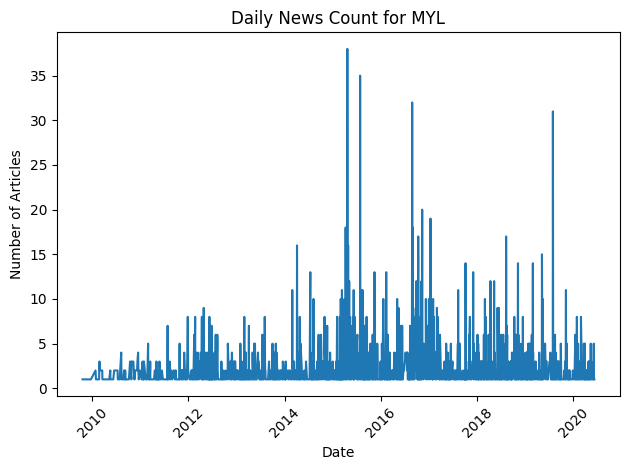

In [15]:
for ticker in pivoted_top:
    ticker_data = pdf_count[pdf_count["Stock_symbol"] == ticker]
    # Sort by date
    ticker_data = ticker_data.sort_values("date_day")
    
    plt.figure()  # new figure
    plt.plot(ticker_data["date_day"], ticker_data["news_count"])
    plt.title(f"Daily News Count for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Number of Articles")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

More heavier but accurate function based language detection 

In [ ]:
def detect_lang(text):
    try:
        return langdetect.detect(text)
    except:
        return "unknown"

detect_lang_udf = udf(detect_lang, StringType())

df_lang = df_csv_5gb.withColumn("detected_lang", detect_lang_udf(df_csv_5gb["Article_title"]))

df_english_only = df_lang.filter(df_lang["detected_lang"] == "en")

In [ ]:
df_english_only.write.mode("overwrite").parquet("../data/raw/english_only.parquet")

## Stock symbol recognition for data enhancement

In [17]:
df_final.show(10)

+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|               Date|       Article_title|Stock_symbol|                 Url|           Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|
+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|2020-06-05 08:30:54|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-06-03 08:45:20|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-05-26 02:30:07|71 Biggest Movers...|           A|https://www.benzi...|          Lisa Levin|  NULL|   NULL|       NULL|        NULL|        

Data Scraped from: https://stock-screener.org/stock-list.aspx?alpha=A

In [9]:
with open("../data/raw/ticker_dict.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert lists back to sets
ticker_dict = {k: set(v) for k, v in data.items()}

In [16]:
df_range = (
    df_final
    .groupBy("Stock_symbol")
    .agg(
        min("Date").alias("min_date"),
        max("Date").alias("max_date")
    )
    .orderBy("Stock_symbol")  # optional for nice ordering
)

df_range.show(50, truncate=False)

+------------+-------------------+-------------------+
|Stock_symbol|min_date           |max_date           |
+------------+-------------------+-------------------+
|NULL        |2006-10-20 02:00:00|2016-08-17 01:59:00|
|A           |2009-04-29 02:00:00|2020-06-05 08:30:54|
|AA          |2009-08-10 02:00:00|2020-06-09 08:52:15|
|AAC         |2010-03-25 01:00:00|2019-11-12 01:00:00|
|AADR        |2012-04-19 02:00:00|2020-04-30 02:00:00|
|AAL         |2011-05-16 02:00:00|2020-06-10 09:21:01|
|AAMC        |2014-01-02 01:00:00|2020-05-11 05:47:11|
|AAME        |2010-04-28 02:00:00|2020-05-15 02:00:00|
|AAN         |2009-08-10 02:00:00|2020-06-10 08:36:34|
|AAOI        |2013-09-26 02:00:00|2020-05-21 02:00:00|
|AAON        |2009-08-10 02:00:00|2020-05-15 05:03:57|
|AAP         |2009-08-13 02:00:00|2020-06-10 07:07:08|
|AAPL        |2020-03-09 01:00:00|2020-06-10 09:33:26|
|AAU         |2009-12-04 01:00:00|2020-02-11 01:00:00|
|AAV         |2009-08-12 02:00:00|2019-08-02 07:03:44|
|AAVL     

Now the intent is to fill the NULL Stock symbols in the Article title or Article column with a dictionary of synonyms created from the data scraped and some functions for processing

In [21]:
broadcast_dict = spark.sparkContext.broadcast(ticker_dict)

In [20]:
### Combine text to find the stock in either column if anyone is NULL 

df_combined = df_final.withColumn(
    "combined_text", 
    concat_ws(" ", col("Article"), col("Article_title"))
)

In [22]:
# UDF
def deduce_ticker_from_text(text):
    if not text:
        return None
    text_lower = text.lower()
    for ticker, synonyms in broadcast_dict.value.items():
        for syn in synonyms:
            if syn in text_lower:
                return ticker
    return None

In [23]:
deduce_ticker_udf = udf(deduce_ticker_from_text, StringType())

In [24]:
df_deduced = df_combined.withColumn(
    "deduced_ticker",
    deduce_ticker_udf(col("combined_text"))
)

In [ ]:
df_deduced.sort(desc("Date")).show(10)

+-------------------+--------------------+------------+--------------------+-----------------+------+-------+-----------+------------+----------------+---------------+--------------------+--------------+
|               Date|       Article_title|Stock_symbol|                 Url|        Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|       combined_text|deduced_ticker|
+-------------------+--------------------+------------+--------------------+-----------------+------+-------+-----------+------------+----------------+---------------+--------------------+--------------+
|2020-06-11 15:12:35|Quicken Loans Pla...|         WFC|https://www.benzi...|   Jason Shubnell|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|Quicken Loans Pla...|             A|
|2020-06-11 15:11:20|PG&E Corp Reports...|         PCG|https://www.benzi...|Benzinga Newsdesk|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|PG&E Corp Reports

### NLP based deduction

In [28]:
rows = []
for ticker, synonyms in ticker_dict.items():
    for syn in synonyms:
        rows.append(Row(synonym=syn, ticker=ticker))

synonyms_df = spark.createDataFrame(rows)  # columns: synonym, ticker

In [29]:
synonyms_df.show(10)

+--------------------+------+
|             synonym|ticker|
+--------------------+------+
|                ap.w|  AP.W|
|ampcopittsburgh c...|  AP.W|
|          alumis inc|  ALMS|
|              alumis|  ALMS|
|                alms|  ALMS|
|           argan inc|   AGX|
|                 agx|   AGX|
|               argan|   AGX|
|                arbb|  ARBB|
|   arb iot group ltd|  ARBB|
+--------------------+------+
only showing top 10 rows



In [1]:
import sparknlp
spark = sparknlp.start()  # automatically creates a SparkSession with spark-nlp jars

your 131072x1 screen size is bogus. expect trouble
25/03/31 23:50:24 WARN Utils: Your hostname, Andres-F resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/31 23:50:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/pipe/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/pipe/.ivy2/cache
The jars for the packages stored in: /home/pipe/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8cd5ac64-b61c-49d4-8d28-453de7be2523;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.5.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	f

In [6]:
preproc = prep.PreprocessingPipeline(spark)

Exception in thread "Thread-5" java.lang.NoClassDefFoundError: scala/collection/GenTraversableOnce
	at java.lang.Class.forName0(Native Method)
	at java.lang.Class.forName(Class.java:348)
	at py4j.reflection.CurrentThreadClassLoadingStrategy.classForName(CurrentThreadClassLoadingStrategy.java:40)
	at py4j.reflection.ReflectionUtil.classForName(ReflectionUtil.java:51)
	at py4j.reflection.TypeUtil.forName(TypeUtil.java:243)
	at py4j.commands.ReflectionCommand.getUnknownMember(ReflectionCommand.java:175)
	at py4j.commands.ReflectionCommand.execute(ReflectionCommand.java:87)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassNotFoundException: scala.collection.GenTraversableOnce
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loa

Py4JError: com.johnsnowlabs.nlp.DocumentAssembler does not exist in the JVM

In [9]:
print("Spark version:", spark.version)
sc = spark.sparkContext
print("Spark master:", sc.master)
# If possible:
# print(sc._jvm.org.apache.spark.package$.MODULE$.SPARK_VERSION()) # sometimes helps


Spark version: 3.5.1
Spark master: local[*]
